# <center>Exception Prediction Using Random Forest</center>

### <center>Data Wrangling</center>

|<h4><center>Features</center></h4>|<h4><center>Details</center></h4>|
|------------------|---------------------------------------------------------------|
|<center>EXCEPTION_HOURS</center>|<center>EXCEPTION_HOURS</center>|
|<center>NOTICE</center>|<center>= SHIFT_START_DATE_TIME - EXCEPTION_CREATION_DATE, in hours</center>|
|<center>JOB_FAMILY</center>|<center>DC1000, DC2B00,DC2A00</center>|
|<center>MONTH</center>|<center>Natural Month</center>|
|<center>WEEKDAY</center>|<center>if SHIFT_DATE is weekday, if TRUE, then 1, if FALSE, then 0</center>|
|<center>SITE</center>|<center>St Paul's Hospital, Mt St Joseph, Holy Family, <br>SVH Langara, Brock Fahrni, Youville Residence</center>|

|<h4><center>EARNING_CATEGORY</center></h4>|<h4><center>Original EARNING_CATEGORY</center></h4>|<h4><center>Number of Exceptions</center></h4>|
|------------------|-------------------------------------------|----------|
|<center>Relief Not Needed</center>|<center>Relief Not Needed</center>|<center>94,325</center>|
|<center>Relief Not Found</center>|<center>Relief Not Found</center>|<center>33,955</center>|
|<center>Overtime</center>|<center>Overtime</center>|<center>52,736</center>|
|<center>Straight Time</center>|<center>Regular Relief Utilized, Casual at Straight-Time, PT Over FTE, <br>Miscellaneous Straight-Time, PT Employee Moved - Straight-Time, FT Employee Moved - Straight-Time  </center>|<center>344,042</center>|
|<center>Others</center>|<center>Agency, Insufficient Notice, On-Call</center>|<center>18,857</center>|



### <center>Model Accuracy with "Relief Not Needed"<center>
<img src="../imgs/davy3.png">

### <center>Model Accuracy with "Relief Not Needed"<center>
<img src="../imgs/davy4.png">

### <center>Chanllenges and concerns<center>

- Inbalanced data


- Missing vital features


- Unblanced Data wrangling method


In [1]:
# base packages
import pandas as pd
import numpy as np

# data wrangling
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

# model
from sklearn.linear_model import LinearRegression

# visualization
import matplotlib.pyplot as plt

In [2]:
# read data
raw = pd.read_csv("../data/train.csv")

/Users/marcelle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Overtime Analysis

- Assume we want to predict number of exceptions backfilled by "overtime" one week ahead
- Use information that is already recorded in the system

Features used:

- Week of year
- Day of week
- Number of exceptions already created

Features to consider:

- Operation hours
- Holiday

# Job Family: DC1000

In [3]:
# consider only job family DC1
dc1 = raw[(raw['JOB_FAMILY'] == "DC1000")]
dc1.shape

(643567, 52)

In [4]:
# variable: number of exceptions created before 48 hours
two_day = dc1[dc1['EXCEPTION_CREATION_TO_SHIFTSTART_MINUTES'] < -2880]
two_day = two_day.groupby(['SHIFT_DATE']).size()
two_day = pd.DataFrame(two_day)
two_day = two_day.rename({0:"two_day"}, axis=1)
two_day.head()

,two_day
SHIFT_DATE,
2012-12-31,288
2013-01-01,124
2013-01-02,210
2013-01-03,218
2013-01-04,228


Number of exceptions already created

- `EXCEPTION_CREATION_TO_SHIFTSTART_MINUTES < - 10080`

In [5]:
# variable: number of exceptions created before one week
one_week = dc1[(dc1['EXCEPTION_CREATION_TO_SHIFTSTART_MINUTES'] < - 10080)]
one_week = one_week.groupby(['SHIFT_DATE']).size()
one_week = pd.DataFrame(one_week)
one_week = one_week.rename({0:"one_week"}, axis=1)
one_week.head()

,one_week
SHIFT_DATE,
2012-12-31,273
2013-01-01,115
2013-01-02,196
2013-01-03,198
2013-01-04,216


Weeks and days

- One-hot coding

In [6]:
# variable: dates
dates = dc1
dates = dates.groupby(['SHIFT_DATE']).size().reset_index()
dates["week"] = dates["SHIFT_DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[1])
dates["weekday"] = dates["SHIFT_DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[2])

# one hot coding
enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
onehot = enc.fit_transform(dates[['week','weekday']])

# add to dataset
for i in range(0,53):
    col_name = "week_" + str(i)
    dates[col_name] = onehot[:,i]
    
for i in range(53,60):
    col_name = "day_" + str(i-52)
    dates[col_name] = onehot[:,i]

# drop columns
dates = dates.drop([0, 'week', 'weekday'], axis=1)
dates = dates.set_index('SHIFT_DATE')

dates.head()

,week_0,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,...,week_50,week_51,week_52,day_1,day_2,day_3,day_4,day_5,day_6,day_7
SHIFT_DATE,,,,,,,,,,,,,,,,,,,,,
2012-12-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
# response: number of overtime exceptions
overtime = dc1[dc1['EARNING_CATEGORY'] == "Overtime"]
overtime = overtime.groupby(['SHIFT_DATE']).size()
overtime = pd.DataFrame(overtime)
overtime = overtime.rename({0:"y"}, axis=1)
overtime = overtime.fillna(0)
overtime.head()

,y
SHIFT_DATE,
2012-12-31,68
2013-01-01,24
2013-01-02,54
2013-01-03,59
2013-01-04,72


In [8]:
# dataset used for regression
data = two_day
data = data.join(one_week)
data = data.join(dates)
data = data.join(overtime)

# date, year and week for grouping
data['date'] = data.index
data['year'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[0])
data['week'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[1])
data['weekday'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[2])
data.head()

,two_day,one_week,week_0,week_1,week_2,week_3,week_4,week_5,week_6,week_7,...,day_3,day_4,day_5,day_6,day_7,y,date,year,week,weekday
SHIFT_DATE,,,,,,,,,,,,,,,,,,,,,
2012-12-31,288,273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,68,2012-12-31,2013,1,1
2013-01-01,124,115,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24,2013-01-01,2013,1,2
2013-01-02,210,196,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,54,2013-01-02,2013,1,3
2013-01-03,218,198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,59,2013-01-03,2013,1,4
2013-01-04,228,216,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,72,2013-01-04,2013,1,5


# Linear Regression

Training data:
- 2013, 2015, 2016

Validation data:

- 2017

In [9]:
# split train and validation
train = data[(data["year"] < 2017) & (data["year"] != 2014)]
val = data[data["year"] == 2017]

# sizes
print("train :", train.shape[0])
print("val   :", val.shape[0])

train : 1099
val   : 364


In [10]:
# prepare for regression
X_train = train.iloc[:,:62]
y_train = train.y
X_val = val.iloc[:,:62]
y_val = val.y

# clear possible nan and infinities
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_val = np.nan_to_num(X_val)
y_val = np.nan_to_num(y_val)

In [11]:
reg = LinearRegression().fit(X_train, y_train)

In [12]:
reg.score(X_val,y_val)

0.5816844827486692

In [13]:
# result by day
result_day = {"y": list(y_val), 
          "yhat": list(reg.predict(X_val)), 
          "year": list(val.year),
          "week": list(val.week),
          "weekday": list(val.weekday)}
result_day = pd.DataFrame(result_day)

In [14]:
# check result
result_day['acc'] = np.abs(result_day['y'] - result_day['yhat'])
print("MAE  :",np.mean(result_day['acc']))

MAE  : 11.260027928138353


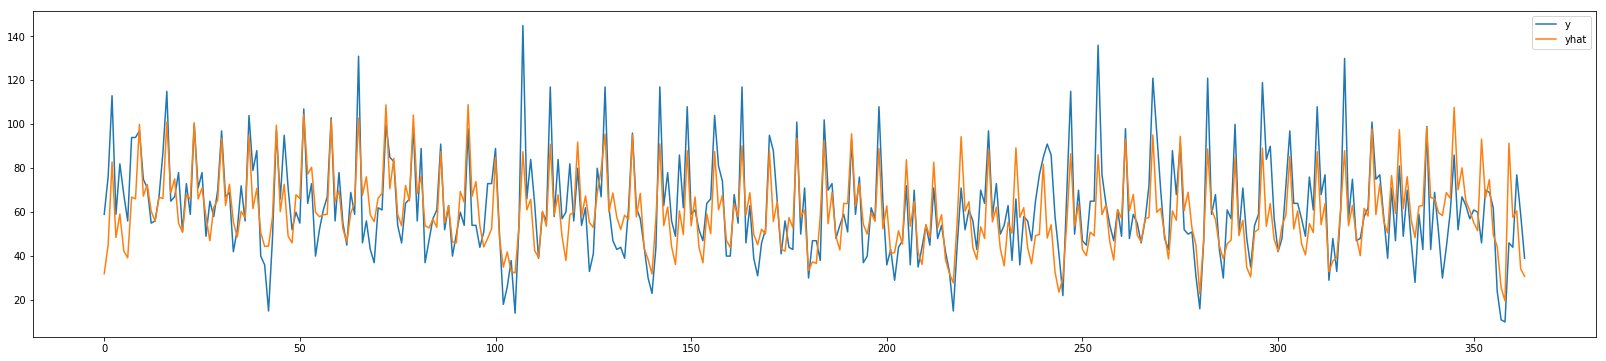

In [15]:
plt.figure(figsize=(28, 6))
# visulize result
plt.plot(result_day.y)
plt.plot(result_day.yhat)
plt.legend()
plt.show()

In [16]:
np.argsort(np.abs(reg.coef_))

array([ 1, 17, 60,  0, 39, 24, 59, 18, 25, 48,  2, 45, 29, 46, 47, 40, 21,
       23, 26, 14, 44, 41, 28, 37, 61, 16, 52, 22, 49, 30, 58, 27, 19, 38,
       20,  8,  7, 56, 42, 15, 13, 55, 50, 51,  6, 43, 12, 31, 33,  5, 10,
       35, 34, 32, 36,  4, 11, 53,  3, 54,  9, 57])

In [17]:
n = [57, 9, 54, 3, 53]

for i in n:
    print(train.columns[i], ":", reg.coef_[i])

day_3 : 28.549441477498554
week_7 : 18.653246737926487
week_52 : -17.96021816600766
week_1 : 17.93113843624276
week_51 : -17.47010765587358


Top 3 coefficients:

- Wednesday
- Week 7
- Week 52

# Job Family: DC2A00

In [18]:
# consider only job family DC2A
dc2a = raw[(raw['JOB_FAMILY'] == "DC2A00")]
dc2a.shape

# variable: number of exceptions created before 48 hours
two_day = dc2a[dc2a['EXCEPTION_CREATION_TO_SHIFTSTART_MINUTES'] < -2880]
two_day = two_day.groupby(['SHIFT_DATE']).size()
two_day = pd.DataFrame(two_day)
two_day = two_day.rename({0:"two_day"}, axis=1)

# variable: number of exceptions created before one week
one_week = dc2a[(dc2a['EXCEPTION_CREATION_TO_SHIFTSTART_MINUTES'] < - 10080)]
one_week = one_week.groupby(['SHIFT_DATE']).size()
one_week = pd.DataFrame(one_week)
one_week = one_week.rename({0:"one_week"}, axis=1)

# variable: dates
dates = dc2a
dates = dates.groupby(['SHIFT_DATE']).size().reset_index()
dates["week"] = dates["SHIFT_DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[1])
dates["weekday"] = dates["SHIFT_DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[2])
# one hot coding
enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
onehot = enc.fit_transform(dates[['week','weekday']])
# add to dataset
for i in range(0,53):
    col_name = "week_" + str(i)
    dates[col_name] = onehot[:,i]
for i in range(53,60):
    col_name = "day_" + str(i-52)
    dates[col_name] = onehot[:,i]
# drop columns
dates = dates.drop([0, 'week', 'weekday'], axis=1)
dates = dates.set_index('SHIFT_DATE')

# response: number of overtime exceptions
overtime = dc2a[dc2a['EARNING_CATEGORY'] == "Overtime"]
overtime = overtime.groupby(['SHIFT_DATE']).size()
overtime = pd.DataFrame(overtime)
overtime = overtime.rename({0:"y"}, axis=1)
overtime = overtime.fillna(0)

# dataset: used for regression
data = two_day
data = data.join(one_week)
data = data.join(dates)
data = data.join(overtime)
# date, year and week for grouping
data['date'] = data.index
data['year'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[0])
data['week'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[1])
data['weekday'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[2])

In [19]:
# split train and validation
train = data[(data["year"] < 2017) & (data["year"] != 2014)]
val = data[data["year"] == 2017]

# prepare for regression
X_train = train.iloc[:,:62]
y_train = train.y
X_val = val.iloc[:,:62]
y_val = val.y

# clear possible nan and infinities
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_val = np.nan_to_num(X_val)
y_val = np.nan_to_num(y_val)

# fit model
reg = LinearRegression().fit(X_train, y_train)

# result by day
result_day = {"y": list(y_val), 
          "yhat": list(reg.predict(X_val)), 
          "year": list(val.year),
          "week": list(val.week),
          "weekday": list(val.weekday)}
result_day = pd.DataFrame(result_day)

In [20]:
# check result
result_day['acc'] = np.abs(result_day['y'] - result_day['yhat'])
print("MAE  :",np.mean(result_day['acc']))

MAE  : 2.219352526542468


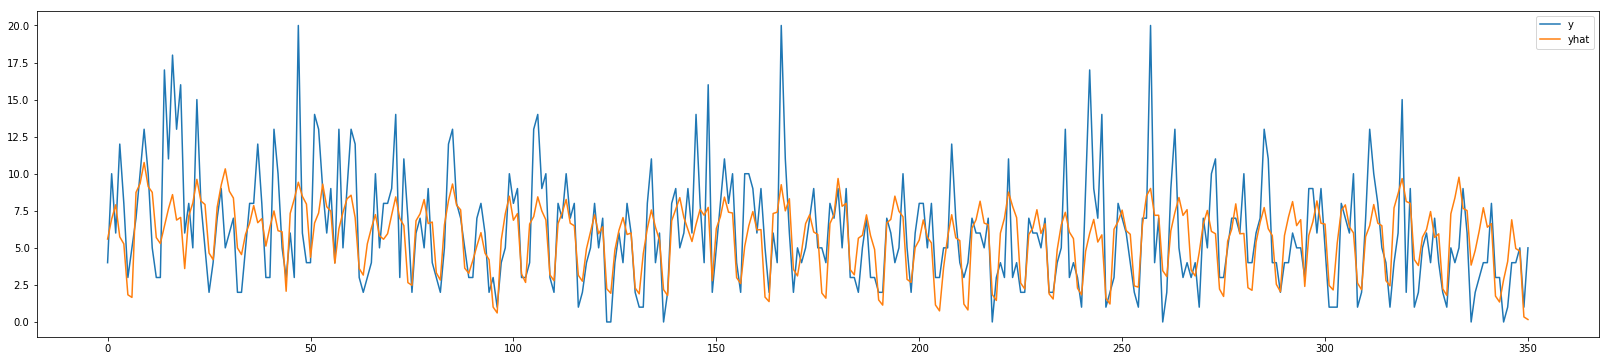

In [21]:
plt.figure(figsize=(28, 6))
# visulize result
plt.plot(result_day.y)
plt.plot(result_day.yhat)
plt.legend()
plt.show()

# Job Family: DC2B00

In [22]:
# consider only job family DC2B
dc2b = raw[(raw['JOB_FAMILY'] == "DC2B00")]
dc2b.shape

# variable: number of exceptions created before 48 hours
two_day = dc2b[dc2b['EXCEPTION_CREATION_TO_SHIFTSTART_MINUTES'] < -2880]
two_day = two_day.groupby(['SHIFT_DATE']).size()
two_day = pd.DataFrame(two_day)
two_day = two_day.rename({0:"two_day"}, axis=1)

# variable: number of exceptions created before one week
one_week = dc2b[(dc2b['EXCEPTION_CREATION_TO_SHIFTSTART_MINUTES'] < - 10080)]
one_week = one_week.groupby(['SHIFT_DATE']).size()
one_week = pd.DataFrame(one_week)
one_week = one_week.rename({0:"one_week"}, axis=1)

# variable: dates
dates = dc2b
dates = dates.groupby(['SHIFT_DATE']).size().reset_index()
dates["week"] = dates["SHIFT_DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[1])
dates["weekday"] = dates["SHIFT_DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[2])
# one hot coding
enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
onehot = enc.fit_transform(dates[['week','weekday']])
# add to dataset
for i in range(0,53):
    col_name = "week_" + str(i)
    dates[col_name] = onehot[:,i]
for i in range(53,60):
    col_name = "day_" + str(i-52)
    dates[col_name] = onehot[:,i]
# drop columns
dates = dates.drop([0, 'week', 'weekday'], axis=1)
dates = dates.set_index('SHIFT_DATE')

# response: number of overtime exceptions
overtime = dc2b[dc2b['EARNING_CATEGORY'] == "Overtime"]
overtime = overtime.groupby(['SHIFT_DATE']).size()
overtime = pd.DataFrame(overtime)
overtime = overtime.rename({0:"y"}, axis=1)
overtime = overtime.fillna(0)

# dataset: used for regression
data = two_day
data = data.join(one_week)
data = data.join(dates)
data = data.join(overtime)
# date, year and week for grouping
data['date'] = data.index
data['year'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[0])
data['week'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[1])
data['weekday'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()[2])

In [23]:
# split train and validation
train = data[(data["year"] < 2017) & (data["year"] != 2014)]
val = data[data["year"] == 2017]

# prepare for regression
X_train = train.iloc[:,:62]
y_train = train.y
X_val = val.iloc[:,:62]
y_val = val.y

# clear possible nan and infinities
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_val = np.nan_to_num(X_val)
y_val = np.nan_to_num(y_val)

# fit model
reg = LinearRegression().fit(X_train, y_train)

# result by day
result_day = {"y": list(y_val), 
          "yhat": list(reg.predict(X_val)), 
          "year": list(val.year),
          "week": list(val.week),
          "weekday": list(val.weekday)}
result_day = pd.DataFrame(result_day)

In [24]:
# check result
result_day['acc'] = np.abs(result_day['y'] - result_day['yhat'])
print("MAE  :",np.mean(result_day['acc']))

MAE  : 1.322522832306338


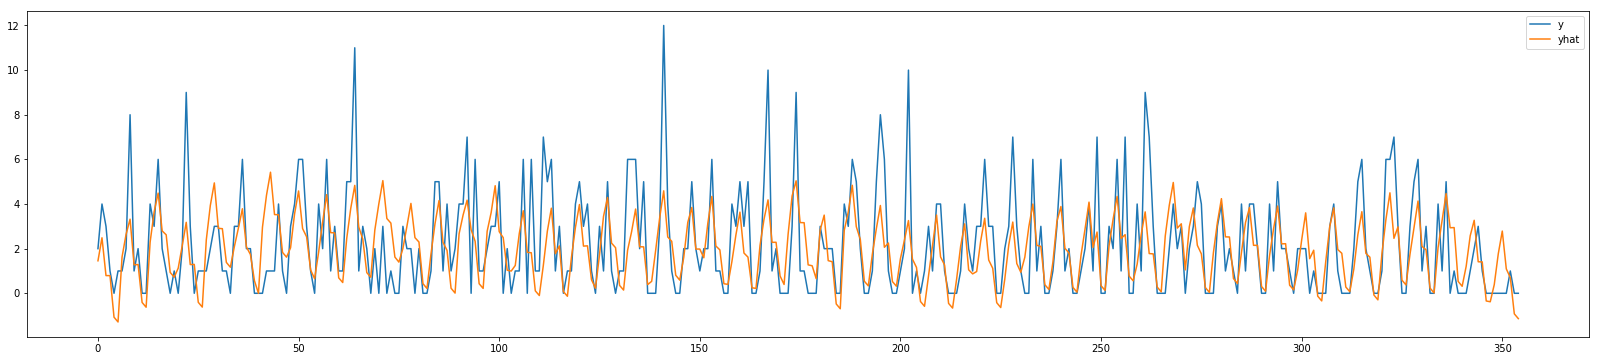

In [25]:
plt.figure(figsize=(28, 6))
# visulize result
plt.plot(result_day.y)
plt.plot(result_day.yhat)
plt.legend()
plt.show()

Improvements:

- Combine features together
- Add holiday feature
- Combine with other models (random forests), adjust with the predictions 

# Dashboard Proposal

<img src="../imgs/dashboard_proposal.png">